In [19]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
from scipy import interpolate
from scipy import signal
from glob import glob
import scipy.ndimage
import matplotlib.colors as colors

from sklearn.linear_model import LinearRegression
import spectrum as spec
from numpy import fft

#import spectrum
plt.rcParams['figure.figsize'] = (15,10)

#data directory for saildrone data
#more on the data here: https://podaac.jpl.nasa.gov/dataset/SAILDRONE_ATOMIC
# DOI = 10.5067/SDRON-ATOM0
data_dir = './data/'
saildrone_filenames = glob(data_dir+'saildrone*.nc')
dy_filenames = glob(data_dir+'sss_collocations_8day_nearest/*.nc')
dy_filenames_NR = glob(data_dir+'sss_collocations_8day_nearest_norepeat/*.nc')
orb_filenames = glob(data_dir+'collocations_with_orbital_sss_norepeat/*.nc')

#output
figs_dir = './figures/'

print(dy_filenames)

['./data/sss_collocations_8day_nearest\\saildrone-gen_5-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-1_minutes-v1.1589306725934_JPLv5.0_8dy_20210511.nc', './data/sss_collocations_8day_nearest\\saildrone-gen_5-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-1_minutes-v1.1589306725934_RSSv4.0_8dy_20210511.nc', './data/sss_collocations_8day_nearest\\saildrone-gen_5-atomic_eurec4a_2020-sd1060-20200117T000000-20200302T235959-1_minutes-v1.1589306886594_JPLv5.0_8dy_20210511.nc', './data/sss_collocations_8day_nearest\\saildrone-gen_5-atomic_eurec4a_2020-sd1060-20200117T000000-20200302T235959-1_minutes-v1.1589306886594_RSSv4.0_8dy_20210511.nc', './data/sss_collocations_8day_nearest\\saildrone-gen_5-atomic_eurec4a_2020-sd1061-20200117T000000-20200302T235959-1_minutes-v1.1589307121602_JPLv5.0_8dy_20210511.nc', './data/sss_collocations_8day_nearest\\saildrone-gen_5-atomic_eurec4a_2020-sd1061-20200117T000000-20200302T235959-1_minutes-v1.1589307121602_RSSv4.0_8dy_20210511.nc

# Read in USV data for all 3 Saildrone
- caluclate density and wind speed
- caluclate distance between successive obs
- caluculate total cumulative distance
- switch from time to cumulative distance as index
- interpolate data onto grid


In [16]:
ds=[]
for iusv in range(6):
    fname=dy_filenames[iusv]
    if 'JPL' in fname:
        continue
    print(fname)
    ds_usv=xr.open_dataset(fname).rename({'SAL_CTD_MEAN':'SAL_SBE37_MEAN','TEMP_CTD_MEAN':'TEMP_SBE37_MEAN'})
    
    #[print(var) for var in ds_usv]
    #ds_usv = [ds_usv.rename({var:'sat_smap_sss'}) if var=='sat_sss_smap' else 999 for var in ds_usv]
    #p = [q.index(v) if v in q else 99999 for v in vm]
    
    #for var in ds_usv:
    #    ds_usv = ds_usv.rename({'sat_sss_smap':'sat_smap_sss'}) 
    #fname=saildrone_filenames[iusv]
    #ds_usv=xr.open_dataset(fname).isel(trajectory=0).swap_dims({'obs':'time'}).rename({'latitude':'lat','longitude':'lon'})
    #ds_usv.close()
  
    ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)   
    tem=sw.dens0(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN)
    ds_usv['density_mean']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.alpha(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['alpha_ME']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.beta(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['beta_MEAN']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['lat']=ds_usv.lat.interpolate_na(dim='time')
    ds_usv['lon']=ds_usv.lon.interpolate_na(dim='time')
    xlat, xlon = ds_usv.lat, ds_usv.lon
    dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
    dkm2=np.append(dkm2,dkm2[66238]) #add on last point
    dkm3 = dkm2.cumsum()
    ds_usv['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_usv.time})
    ds.append(ds_usv)
ds_saildrone = xr.concat(ds, dim='trajectory')
#ds_saildrone = ds.copy(deep=True)


./data/sss_collocations_8day_nearest\saildrone-gen_5-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-1_minutes-v1.1589306725934_RSSv4.0_8dy_20210511.nc
./data/sss_collocations_8day_nearest\saildrone-gen_5-atomic_eurec4a_2020-sd1060-20200117T000000-20200302T235959-1_minutes-v1.1589306886594_RSSv4.0_8dy_20210511.nc
./data/sss_collocations_8day_nearest\saildrone-gen_5-atomic_eurec4a_2020-sd1061-20200117T000000-20200302T235959-1_minutes-v1.1589307121602_RSSv4.0_8dy_20210511.nc


# plot scatter plot for salinity

In [28]:
ds=[]
for iusv in range(6):
    fname=dy_filenames_NR[iusv]
    if 'JPL' in fname:
        continue
    print(fname)
    ds_usv=xr.open_dataset(fname).rename({'SAL_CTD_MEAN':'SAL_SBE37_MEAN','TEMP_CTD_MEAN':'TEMP_SBE37_MEAN'})
    ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)
    ds.append(ds_usv)
ds_saildrone = xr.concat(ds, dim='trajectory')

./data/sss_collocations_8day_nearest_norepeat\saildrone-gen_5-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-1_minutes-v1.1589306725934_RSSv4.0_8dy_20210511norep_20210511.nc
./data/sss_collocations_8day_nearest_norepeat\saildrone-gen_5-atomic_eurec4a_2020-sd1060-20200117T000000-20200302T235959-1_minutes-v1.1589306886594_RSSv4.0_8dy_20210511norep_20210511.nc
./data/sss_collocations_8day_nearest_norepeat\saildrone-gen_5-atomic_eurec4a_2020-sd1061-20200117T000000-20200302T235959-1_minutes-v1.1589307121602_RSSv4.0_8dy_20210511norep_20210511.nc


Text(0, 0.5, '$\\Delta$ Salinity SMAP - USV (psu)')

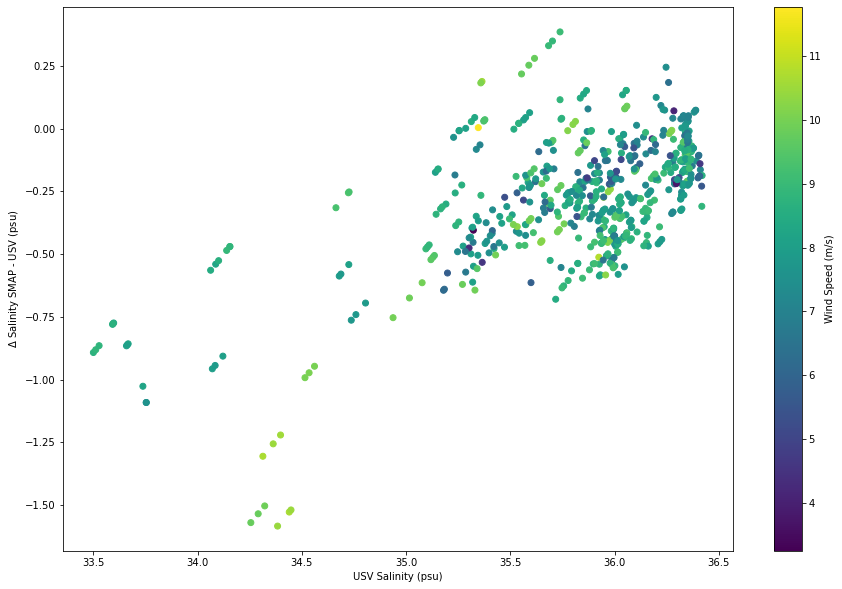

In [29]:
plt.scatter(ds_saildrone.SAL_SBE37_MEAN,ds_saildrone.SAL_SBE37_MEAN-ds_saildrone.sat_sss_smap,c=ds_saildrone.wspd)
plt.colorbar(label='Wind Speed (m/s)')
plt.xlabel('USV Salinity (psu)',fontsize=10)
plt.ylabel('$\Delta$ Salinity SMAP - USV (psu)',fontsize=10)

In [17]:
def cal_pdf(data_in,var): 
    #make arrays for sampling at different length scales
    length_scale = np.arange(.1,200,1)
    # create the empty data arrays to store the normalized histograms (normalized the *100 for percentage count)
    xx_in = np.arange(0,.2,.001)
    xx_in2 = np.arange(0,.2-.001,.001)
    data = np.zeros((len(length_scale),len(xx_in2)))
    ddn=xr.DataArray(data,dims=('length_scale','gradx'),coords={'length_scale':length_scale,'gradx':xx_in2})
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
        ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
        for ilen2,len2 in enumerate(length_scale):
            dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
            ds4 = ds3.interp(dist_total=dist_interp)       
            den_grad =  np.abs(np.gradient(ds4[var])/len2)
            result,xx = np.histogram(den_grad,bins=xx_in)
            ddn[ilen2,:]=ddn[ilen2,:]+result
    for ilen2,len2 in enumerate(length_scale):
        ddn[ilen2,:]=ddn[ilen2,:]/sum(ddn[ilen2,:])*100  #normalize & turn into percent

    return ddn

def cal_spectrum(data,dt,var):
    #var = 'density_mean'
    #dt = 0.08  #set sampling interpolation to 80m
    #data = ds_saildrone
    ps_all_fft,ps_all_mt,ps_all_per=[],[],[]
    mindist = int(data.dist_total.max(dim='time').min().data-1)
    print(mindist)
    for iusv in range(3):
        #read in saildrone data, make coordinatin system total distance from start
        #interpolate onto regular distances
        #detrend
        ds_usv = data.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
        ds3 = ds2.swap_dims({'time':'dist_total'})
        ds3 = ds3.sel(dist_total=slice(0,mindist))        
        dist_interp = np.arange(ds2.dist_total[0],mindist,dt)
        ds4 = ds3.interp(dist_total=dist_interp)
        den = ds4[var].interpolate_na(dim='dist_total')
        den = den.where(np.isfinite(den),drop=True)
        N = len(den)
        print(N)
        ilen_N = N //2
        ds4_detrend = signal.detrend(den)  

        # classical FFT
        yf = fft.fft(ds4_detrend)
        xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)
        ps_all_fft.append(yf[0:ilen_N])

        #periodogram
        per_freq, Pxx_den = signal.periodogram(ds4_detrend,1/dt)  #fs = sampled at .08km or 80m
        ps_all_per.append(yf[0:ilen_N])

        #multitaper
        NW,k=2.5,4
        [tapers, eigen] = spec.dpss(N, NW, k)
        Sk_complex, weights, eigenvalues=spec.pmtm(ds4_detrend, e=eigen, v=tapers, NFFT=N, show=False)
        # The multitapered method
        Sk = abs(Sk_complex)**2
        Sk = np.mean(Sk * np.transpose(weights), axis=0) * dt
        ps_all_mt.append(Sk[0:ilen_N])

    sfft,sper,smt = np.mean(np.vstack(ps_all_fft),axis=0),np.mean(np.vstack(ps_all_per),axis=0),np.mean(np.vstack(ps_all_mt),axis=0)
    return sfft,sper,smt,xf


def make_plot(data_in,text1,xf,sper,slp1,slp2,pk1,figure_name_out):
    #data_in = ddn
    #text1 = 'Saildrone'
    length_scale = np.arange(.1,200,1)
    xx_in = np.arange(0,.2,.001)
    xx_in2 = np.arange(0,.2-.001,.001)
    print(len(length_scale),len(xx_in))
    fig = plt.figure(figsize=(14,10))
    tem=ddn
    tem = tem.where(tem>.003)
    Z=tem.T
    ax = plt.pcolormesh(length_scale,xx_in2,Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),vmin=.01,vmax=100,cmap='hot')
    plt.text(15,0.178,'(a)'+text1,fontsize=16,color='k')
    plt.xlabel('Length scale (km)',fontsize=16)
    plt.ylabel('Density gradient (kg m$^{-3}$ km$^{-1}$)',fontsize=16)
    cb = plt.colorbar()
    cb.set_label(label='Percent count',fontsize=16)

    plt.axes([.33, .46, .4, .4])
    
    iend = 34000
    plt.loglog(xf[0:iend],abs(sper[0:iend])**2 / N * dt)
    #plt.loglog(xf[0:iend],smt[0:iend],'k')
    #iline=1/28
    #plt.axvline(iline,c='g')
    cc=['m','r','c','b']
    
    for i in range(len(slp1)):
        istart,iend=slp1[i],slp2[i]
        XX = np.log(xf[istart:iend])
        YY = np.log(abs(sper[istart:iend])**2 / N * dt)
        reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
        a = float(reg.coef_)
        b = -1*float(reg.intercept_)
        plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),cc[i],lw=2) #test from fit
        slp_str = 'slope = '+"{:.1f}".format(a)
        plt.text(.5,.05-.04*i,slp_str,fontsize=16,color=cc[i])

    plt.xlim([10e-4,7])
    plt.ylim([10e-11,10e1])
    plt.xticks(ticks=[.001,.01,.1,1],labels=['1000','100','10','1'])
    plt.xlabel('Wavelength (km)')
    plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')
    plt.grid()

    for i in range(len(pk1)):
        plt.axvline(pk1[i],c='g')
        plt.text(pk1[i]+.005,1,'peak = '+"{:.0f}".format(1/0.03585)+' km',fontsize=16,color='g')

    plt.savefig(figure_name_out)

    #print(1/xf[20],1/xf[2300],1/xf[500],1/xf[20000])
    #print(1/pk1)
    return


In [18]:
ddn = cal_pdf(ds_saildrone,'density_mean')
sfft,sper,smt,xf = cal_spectrum(ds_saildrone,0.08,'density_mean')
make_plot(ddn,'Saildrone',xf,sper,slp1,slp2,pk1,figure_name_out)

5551
69386
69386
69386


NameError: name 'slp1' is not defined

In [ ]:
ddn = cal_pdf(ds_saildrone,'density_mean')
sfft,sper,smt,xf = cal_spectrum(ds_saildrone,0.08,'density_mean')
make_plot(ddn,'Saildrone',xf,sper,slp1,slp2,pk1,figure_name_out)

# make figure

# Time spectrum

In [ ]:

var = 'TEMP_SBE37_MEAN'
#var = 'TEMP_AIR_MEAN'
dt = 1  #set sampling interpolation to 80m
data = ds_saildrone
ps_all_fft,ps_all_mt,ps_all_per=[],[],[]
#mindist = int(data.dist_total.max(dim='time').min().data-1)
#print(mindist)

for iusv in range(3):
    
    #read in saildrone data, make coordinatin system total distance from start
    #interpolate onto regular distances
    #detrend
    ds_usv = data.isel(trajectory=iusv)
    
    #den = ds_usv[var].interpolate_na(dim='time')
    #den = den.where(np.isfinite(den),drop=True)
    #ds4_detrend_smooth = signal.detrend(den)

    
    #ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    #ds3 = ds2.swap_dims({'time':'dist_total'})
    #ds3 = ds3.sel(dist_total=slice(0,mindist))        
    #dist_interp = np.arange(ds2.dist_total[0],mindist,dt)
    #ds4 = ds3.interp(dist_total=dist_interp)
    den = ds_usv[var].interpolate_na(dim='time')
    den = den.where(np.isfinite(den),drop=True)
    N = len(den)
    print(N)
    ds4_detrend = signal.detrend(den)  

    # classical FFT
    yf = fft.fft(ds4_detrend)
    xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)
    ps_all_fft.append(yf[0:34700])

    #periodogram
    per_freq, Pxx_den = signal.periodogram(ds4_detrend,1/dt)  #fs = sampled at .08km or 80m
    ps_all_per.append(yf[0:34700])
    
    #multitaper
    NW,k=2.5,4
    [tapers, eigen] = spec.dpss(N, NW, k)
    Sk_complex, weights, eigenvalues=spec.pmtm(ds4_detrend, e=eigen, v=tapers, NFFT=N, show=False)
    # The multitapered method
    Sk = abs(Sk_complex)**2
    Sk = np.mean(Sk * np.transpose(weights), axis=0) * dt
    ps_all_mt.append(Sk[0:34700])
    
sfft,sper,smt = np.mean(np.vstack(ps_all_fft),axis=0),np.mean(np.vstack(ps_all_per),axis=0),np.mean(np.vstack(ps_all_mt),axis=0)

iend = 30000
plt.loglog(xf[0:iend],abs(sper[0:iend])**2 / N * dt)
plt.loglog(xf[0:iend],smt[0:iend],'k')

#iline=1/28
#plt.axvline(iline,c='g')

istart,iend=20,1000
XX = np.log(xf[istart:iend])
YY = np.log(abs(sper[istart:iend])**2 / N * dt)
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),'m') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,5,slp_str,fontsize=16,color='m')

istart,iend=1000,20000
XX = np.log(xf[istart:iend])
YY = np.log(abs(sper[istart:iend])**2 / N * dt)
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),'r') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,1,slp_str,fontsize=16,color='r')

plt.loglog([1/(60*12),1/(60*12)],[10e-5,10e4],'y')
plt.loglog([1/(60*24),1/(60*24)],[10e-5,10e4],'g')
#plt.loglog(freq[0:1000], Pxx_den[0:1000],'b')

plt.xlim([10e-6,1])
plt.ylim([10e-11,10e3])
plt.xticks(ticks=[.0001,.001,.01,.1,1],labels=['10000','1000','100','10','1'])
plt.xlabel('Time (s)')
plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')
plt.grid()
plt.savefig('./figures/PSD_den_grad_usv_multitaper_time.png')
